<a href="https://colab.research.google.com/github/DRSNAJ/CNN-LSTM-RNN-image-description-generator/blob/main/news_sentiment_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
from datetime import datetime
import time
import plotly.express as px

from transformers import TFBertModel, BertTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/datasets/news_tweets')

['tweets_bbc.csv', 'tweets_cnn.csv', 'tweets_eco.csv']

In [ ]:
dataset_src = '/content/drive/MyDrive/Colab Notebooks/datasets/news_tweets'
news_df = pd.DataFrame()

datainfo = {"bbc":{"start_data":None,"end_data":None,"num_tweets":None},
            "cnn":{"start_data":None,"end_data":None,"num_tweets":None},
            "eco":{"start_data":None,"end_data":None,"num_tweets":None}}

all_outlets = ['bbc', 'cnn', 'eco']

for fileItem in os.listdir(dataset_src):
  data = pd.read_csv(dataset_src + "/" + fileItem)
  data['timestamp'] = pd.to_datetime((data['date'] + ' ' + data['time']))

  for i in all_outlets:
    data[i] = 0

  try:
    outlet = 'unknown'
    if (fileItem == 'tweets_bbc.csv'):
      outlet = "bbc"
    elif (fileItem == 'tweets_cnn.csv'):
      outlet = "cnn"
    elif (fileItem == 'tweets_eco.csv'):
      outlet = "eco"
    else:
      outlet = 'unknown'

    data[outlet] = 1

    datainfo[outlet]["start_data"] = data[data['timestamp'] == data['timestamp'].min()]['timestamp'].item()
    datainfo[outlet]["end_data"] = data[data['timestamp'] == data['timestamp'].max()]['timestamp'].item()
    datainfo[outlet]["num_tweets"] = data.shape[0]

  except Exception as e:
    print(f"File not found: {e}")


  news_df = pd.concat([news_df,data])
  news_df = news_df[['timestamp','bbc','cnn','eco','tweet']]

news_df['timestamp'] = news_df['timestamp'].round('min') # minute


# Regular expression pattern to match URLs
tweet_link_format = r'(\s)http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# Replace URLs with an empty string
news_df['tweet'] = news_df['tweet'].str.replace(tweet_link_format, '', regex=True)
news_df['tweet'] = news_df['tweet'].str.replace('. Follow live updates:', '', regex=True)

# Printing results
total_tweets = 0
data_tbl = '\n==================================DATA SUMMARY===================================\n|Outlet \t|Start Date \t\t|End Date \t\t|Tweets \t|\n|---------------|-----------------------|-----------------------|---------------|\n'
for outlet in all_outlets:
  data_tbl = data_tbl + '|'+ outlet + '\t\t|'+ str(datainfo[outlet]["start_data"]) + '\t|'+ str(datainfo[outlet]["end_data"]) + '\t|'+ str(datainfo[outlet]["num_tweets"]) +'\t\t|\n'
  total_tweets = total_tweets + datainfo[outlet]["num_tweets"]
data_tbl = data_tbl +'|---------------|-----------------------|-----------------------|---------------|\n' + '|\t\t|\t\t\t|\t\t\t|' + str(total_tweets) + '\t\t|'
data_tbl = data_tbl +'\n=================================================================================\n'
print(data_tbl)

<ipython-input-81-b5797ba07313>:11: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_src + "/" + fileItem)
<ipython-input-81-b5797ba07313>:11: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_src + "/" + fileItem)
<ipython-input-81-b5797ba07313>:11: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_src + "/" + fileItem)



==================================DATA SUMMARY===================================
|Outlet 	|Start Date 		|End Date 		|Tweets 	|
|---------------|-----------------------|-----------------------|---------------|
|bbc		|2010-01-01 19:40:04	|2021-07-02 15:28:43	|34547		|
|cnn		|2010-01-01 06:58:23	|2021-07-05 05:08:12	|55236		|
|eco		|2010-01-01 21:20:14	|2021-07-05 04:59:39	|254413		|
|---------------|-----------------------|-----------------------|---------------|
|		|			|			|344196		|



In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/datasets/forex_data/DAT_MT_GBPUSD_M1'

forex_data = pd.DataFrame()
column_names = ['date','time','open','high','low','close','na']

for f in os.listdir(data_path):
  data = pd.read_csv(data_path + '/' + f, names=column_names)

  # Formatting data and creating timestamps
  data['date'] = data['date'].str.replace('.', '-')
  data['timestamp'] = pd.to_datetime((data['date'] + ' ' + data['time']))

  forex_data = pd.concat([forex_data,data])

# Removing duplicates and sorting by time.
forex_data = forex_data[['timestamp','open','high','low','close']].drop_duplicates().sort_values(by='timestamp')

# Adding in missing timestamps and interpolating the forex prices between those values.
forex_data = forex_data.set_index('timestamp')[['open','high','low','close']].asfreq(freq='60s').interpolate()

# Smoothing out closing data over 4H to remove noise using Exponential Moving Average and Simple Moving Average
period = 60*4
forex_data['4hemw'] = forex_data['close'].ewm(span=period, adjust=False).mean() # Exponential Moving Average
forex_data['ma'] = forex_data['close'].rolling(window=period).mean() # Simple Moving Average

# Calculating the rate of change of the exponential moving average
forex_data['fxgrad'] = np.gradient(forex_data['4hemw'])
forex_data['fxgrad'] = forex_data['fxgrad'].rolling(window=period).mean() # can try ema here as well


In [ ]:
# combining forex data and tweets
label_tweets = pd.merge(news_df, forex_data, left_on='timestamp', right_index=True).sort_values(by='timestamp')
print(list(label_tweets.columns))

# Positive gradients are labled +1 the middle zeroRange percentile is 0 and negative gradients are -1
zeroRange = 0.50
zeroBottom = label_tweets['fxgrad'].quantile(0.5 - zeroRange/2)
zeroTop = label_tweets['fxgrad'].quantile(0.5 + zeroRange/2)

label_tweets['label'] = label_tweets['fxgrad'].apply(lambda x: 0 if x < 0 else x )
label_tweets['label'] = label_tweets['fxgrad'].apply(lambda x: 2 if x > 0 else x )

label_tweets.loc[((label_tweets['fxgrad'] > zeroBottom) & (label_tweets['fxgrad'] < zeroTop),'label')] = 1


['timestamp', 'bbc', 'cnn', 'eco', 'tweet', 'open', 'high', 'low', 'close', '4hemw', 'ma', 'fxgrad']


In [ ]:
label_tweets

,timestamp,bbc,cnn,eco,tweet,open,high,low,close,4hemw,ma,fxgrad,label
55216,2010-01-03 18:55:00,0,1,0,"U.S., Britain close embassies in Yemen because...",1.61360,1.61360,1.61360,1.61360,1.611969,NaN,NaN,NaN
55215,2010-01-04 04:30:00,0,1,0,Iran soccer chief apologizes for Israel New Ye...,1.61670,1.61790,1.61660,1.61790,1.612027,1.610909,0.000010,2.0
254410,2010-01-04 05:46:00,0,0,1,Spending the holidays at the airport #economist,1.61890,1.61900,1.61860,1.61860,1.616009,1.614389,0.000027,2.0
55214,2010-01-04 06:11:00,0,1,0,Security breach at Newark Airport; TSA: Termin...,1.61960,1.62060,1.61960,1.62040,1.616485,1.615482,0.000030,2.0
55213,2010-01-04 06:25:00,0,1,0,Terminal C at Newark Airport shut down after m...,1.62210,1.62220,1.62150,1.62150,1.617017,1.616318,0.000034,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,2021-07-05 04:30:00,0,0,1,Our China economics editor @S_Rabinovitch is p...,1.38500,1.38503,1.38474,1.38488,1.383608,1.383242,0.000005,2.0
2,2021-07-05 04:30:00,0,0,1,“There’s no other place in the world where you...,1.38500,1.38503,1.38474,1.38488,1.383608,1.383242,0.000005,2.0
1,2021-07-05 04:42:00,0,0,1,The proposed minimum tax of at least 15% would...,1.38521,1.38528,1.38518,1.38528,1.383745,1.383388,0.000006,2.0
0,2021-07-05 05:00:00,0,0,1,Last spring at the Palais des Festivals in Can...,1.38499,1.38515,1.38494,1.38499,1.383971,1.383615,0.000007,2.0


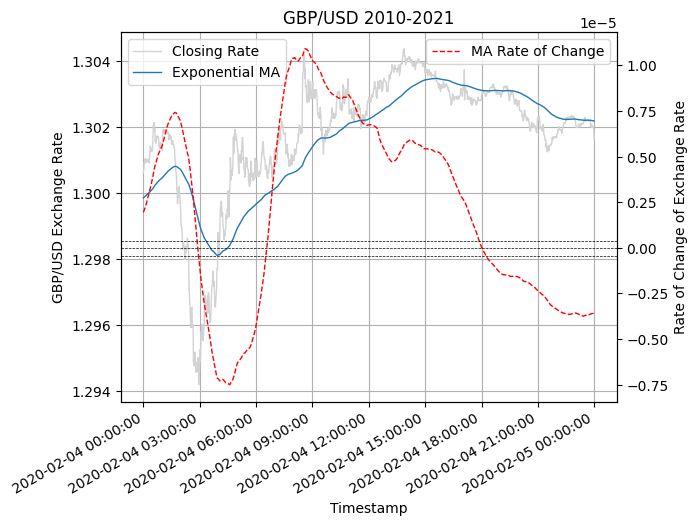

In [ ]:
date_rng = [datetime.strptime('2020/02/04 00:00:00', '%Y/%m/%d %H:%M:%S'), datetime.strptime('2020/02/05 00:00:00', '%Y/%m/%d %H:%M:%S')]
plt_data = forex_data[date_rng[0]:date_rng[1]]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax1.xaxis.set_major_formatter(xfmt)
ax2.xaxis.set_major_formatter(xfmt)

ax1.plot(plt_data.index, plt_data['close'], linewidth=1, color='lightgray')
ax1.plot(plt_data.index, plt_data['4hemw'], linewidth=1)
ax2.plot(plt_data.index, plt_data['fxgrad'], 'r--', linewidth=1)

for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax1.legend(['Closing Rate', 'Exponential MA'])
ax2.legend(['MA Rate of Change'])
ax1.grid(True)


ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
ax2.axhline(y=label_tweets['fxgrad'].quantile(0.60), color='k', linestyle='--', linewidth=0.5)
ax2.axhline(y=label_tweets['fxgrad'].quantile(0.40), color='k', linestyle='--', linewidth=0.5)

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('GBP/USD Exchange Rate')
ax2.set_ylabel('Rate of Change of Exchange Rate')
ax1.set_title('GBP/USD 2010-2021')
plt.show()

In [ ]:
label_tweets.loc[label_tweets['label'] == 2]

,timestamp,bbc,cnn,eco,tweet,open,high,low,close,4hemw,ma,fxgrad,label
55215,2010-01-04 04:30:00,0,1,0,Iran soccer chief apologizes for Israel New Ye...,1.61670,1.61790,1.61660,1.61790,1.612027,1.610909,0.000010,2.0
254410,2010-01-04 05:46:00,0,0,1,Spending the holidays at the airport #economist,1.61890,1.61900,1.61860,1.61860,1.616009,1.614389,0.000027,2.0
55214,2010-01-04 06:11:00,0,1,0,Security breach at Newark Airport; TSA: Termin...,1.61960,1.62060,1.61960,1.62040,1.616485,1.615482,0.000030,2.0
55213,2010-01-04 06:25:00,0,1,0,Terminal C at Newark Airport shut down after m...,1.62210,1.62220,1.62150,1.62150,1.617017,1.616318,0.000034,2.0
55206,2010-01-05 01:17:00,0,1,0,Power restored at Reagan National Airport,1.61160,1.61170,1.61140,1.61140,1.610102,1.609635,0.000004,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,2021-07-05 04:30:00,0,0,1,Our China economics editor @S_Rabinovitch is p...,1.38500,1.38503,1.38474,1.38488,1.383608,1.383242,0.000005,2.0
2,2021-07-05 04:30:00,0,0,1,“There’s no other place in the world where you...,1.38500,1.38503,1.38474,1.38488,1.383608,1.383242,0.000005,2.0
1,2021-07-05 04:42:00,0,0,1,The proposed minimum tax of at least 15% would...,1.38521,1.38528,1.38518,1.38528,1.383745,1.383388,0.000006,2.0
0,2021-07-05 05:00:00,0,0,1,Last spring at the Palais des Festivals in Can...,1.38499,1.38515,1.38494,1.38499,1.383971,1.383615,0.000007,2.0


# Loading Models

In [ ]:
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model_tf = TFBertModel.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
[x_train, x_test, y_train, y_test] = train_test_split(label_tweets["tweet"].tolist(),label_tweets["label"].tolist(), test_size=0.1, random_state=0)
print("Training Dataset Size: " + str(len(x_train)))
print("Testing Dataset Size: " + str(len(x_test)))

Training Dataset Size: 309753
Testing Dataset Size: 34418


In [ ]:
train_encodings = tokenizer(x_train, truncation=True, padding=True)
test_encodings = tokenizer(x_test, truncation=True, padding=True)

In [ ]:
print(train_encodings)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

